# 4. VIENNA dataset, classification, select best 5/3 variables with RFE

- use recursive feature elimination (RFE) to find subsets of 5 or 3 variables which work the best
- measure performance of different parameter sets in 75 cross-validations
- use kNN-imputed data

<sub>original notebook name: `VICIS_06_HVPG_prediction_systematic_evaluation.ipynb`</sub>  
<sub>note: values reported in the manuscript come from a later rerun on non-scaled data</sub>

In [2]:
import numpy as np     # numerical computing tools
import pandas as pd    # data science library

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# scaling
from sklearn.preprocessing import StandardScaler

# prediction models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# feature selection
from sklearn.feature_selection import SelectKBest, RFE

# metrics
from sklearn.metrics import plot_roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

# do not show Convergence warning when MLP cannot be trained well
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# ceil function to round numbers up (for visualizations)
from math import ceil

set_matplotlib_formats("retina")
sns.set_theme(style="white")

## Functions

#### Repeat CV multiple times, look at mean AUCs

In [3]:
# repeat CV n times and return mean AUC value for each model
# analyze=True plots the results as well
def repeat_CV_get_AUC(models, names, n, X, y, silent = True, analyze = False, title=""):
    
    # used later so that each of the 15 cross validations is the same for each model
    random_states = np.random.randint(10000, size = n)
    
    # variable to store mean AUCs from each CV
    mean_AUCs = {names[i]:None for i in range(len(names))}
    
    for clf, name in zip(models, names):
        mean_AUCs_model = []
        silent or print(f"{name: <25}", end = "")
        for j in range(n):
            cv = StratifiedKFold(n_splits=5, random_state = random_states[j], shuffle=True)
            mean_AUCs_model.append(get_AUC_CV(clf, cv, X, y))
            silent or print("*", end = "")
        silent or print()
        mean_AUCs[name] = mean_AUCs_model
        
    if silent: print("", end="")
        
    mean_AUCs = pd.DataFrame(mean_AUCs)    
    if analyze:
        analyze_mean_AUCs(mean_AUCs, n, title=title)
    return pd.DataFrame(mean_AUCs)

#### Get mean AUC from a single CV

In [4]:
# returns mean AUC
def get_AUC_CV(clf, cv, X, y):
    aucs = []  # save auc value for each fold (to calculate the mean)

    for i, (train, test) in enumerate(cv.split(X, y)):  
        clf.fit(X.iloc[train], y.iloc[train])
        y_probas = clf.predict_proba(X.iloc[test])[:,1]
        aucs.append(roc_auc_score(y.iloc[test], y_probas))
    
    mean_auc = np.mean(aucs)
    
    return mean_auc

#### Take mean AUCs from repeated CVs, visualize mean AUCs and show table with median of means

In [5]:
def analyze_mean_AUCs(mean_AUCs, n, title="", swarm_only=True):
    # convert to so-called long format
    processed = pd.melt(mean_AUCs, value_vars=mean_AUCs.columns)
    
    # get median of mean AUCs across CVs 
    medians = processed.groupby("variable").median().sort_values(by='value', ascending=False).reset_index()
    # round up
    medians.iloc[:,1] = np.round(medians.iloc[:,1], decimals=3)
    medians.columns = ["model", f"median of AUC means ({n} cross-validations)"]
    display(medians)
    
    # get tick labels for swarmplot (show median of AUC means)
    medians.sort_values(by = "model", inplace=True)
    names, values = medians.iloc[:,0], medians.iloc[:,1]
    #new_labels = [f"{uno}\n(median={due})" for uno, due in zip(names, values)]
    new_labels = [f"{uno}\n({due})" for uno, due in zip(names, values)]
    
    # set axes limits and title
    ylim = (.75, .95)
    yticks = np.arange(.75, .951, 0.05).round(2)
    if title:
        title = f"{title}, {n} cross-validations"
    else:
        title = f"Mean AUCs, {n} cross-validations"
     
    # swarmplot
    plt.figure(figsize=(6,6), dpi=75)
    sns.set_theme(context="notebook", style="whitegrid")
    ax = sns.swarmplot(data = processed, x="variable", y = "value")

    plt.xlabel("Model", fontweight="bold", labelpad=10)
    plt.ylabel("Mean AUC", fontweight="bold", labelpad=10)
    plt.title(title, fontweight="bold")
    
    plt.ylim(ylim)
    plt.yticks(yticks)
    ax.set_xticklabels(new_labels)
    plt.show()
    
    if swarm_only:
        return
    
    #boxplot
    plt.figure(figsize=(8,8))
    sns.set_theme(context="notebook", style="whitegrid")
    box_plot = sns.boxplot(data = processed, x="variable", y = "value")

    medians = processed.groupby("variable").median()
    vertical_offset = processed.groupby("variable").median() * 0.005 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick, medians.value[xtick]+.0013, f"{medians.value[xtick]:.3f}", 
                horizontalalignment='center',size='x-small',color='white',weight='bold')

    plt.xlabel("Model", fontweight="bold", labelpad=10)
    plt.ylabel("Mean AUC", fontweight="bold", labelpad=10)
    plt.title(title, fontweight="bold")

    plt.ylim(ylim)
    plt.yticks(yticks)
    plt.show()

    #violin plot
    plt.figure(figsize=(8,8))
    sns.set_theme(context="notebook", style="whitegrid")
    box_plot = sns.violinplot(data = processed, x="variable", y = "value")

    medians = processed.groupby("variable").median()
    vertical_offset = processed.groupby("variable").median() * 0.005 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick, medians.value[xtick]+.002, f"{medians.value[xtick]:.3f}", 
                horizontalalignment='center',size='x-small',color='white',weight='bold')

    plt.xlabel("Model", fontweight="bold", labelpad=10)
    plt.ylabel("Mean AUC", fontweight="bold", labelpad=10)
    plt.title(title, fontweight="bold")

    plt.ylim(ylim)
    plt.yticks(yticks)
    plt.show()

## Load preprocessed dataset, extract and standardize predictor variables and HVPG label

In [6]:
# kNN imputed data
data = pd.read_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_kNN_imputed.pickle")

# predictor variables
X = data.iloc[:, 12:]

# rescale
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# predicted (target) variable
y = data["HVPG_label_code"]

## Load table indicating which variables to use in standard workup

1. standard parameters
2. sophisticated but widely available
3. study/center specific parameters


In [7]:
variables = pd.read_csv("../VICIS_selected_parameters_v3.txt", sep="|", header=None)
variables.columns = ["parameter", "code"]

# see how many of each are there
variables.code.value_counts()

# print standard workup parameters
print(", ".join(list(variables[variables.code == 1]["parameter"])))

SEX_Code, AGE, ETIO_Code, MELD-UNOS, BL_BMI, HR, SYS, DIA, MAP, ERY, HB, HKT, MCV, MCH, MCHC, PLT, WBC, Na, K, Cl, Ca, Ph, Mg, KREA, BUN, BILI, PROTEIN, ALB, CHE, AP, ASAT, ALAT, GGT, LDH, aPTT, FGEN, INR, TPZ%, D-Dim, TRIG, CHOL, GLUC, HDL, LDL, HbA1c, Fe, TF, TFS, FERRITIN, LACT, NH3, CRP, TSH, 25(OH)D, proBNP, FA, VIT_B12


## Get data only for standard workup parameters

In [15]:
X_scaled.columns

Index(['SEX_Code', 'AGE', 'BL_STIFFNESS', 'MELD-UNOS', 'BL_BMI', 'HR', 'SYS',
       'DIA', 'MAP', 'ERY', 'HB', 'HKT', 'MCV', 'MCH', 'MCHC',
       'ERY-DISTRIBUTION', 'PLT', 'MPLTV', 'WBC', 'Na', 'K', 'Cl', 'Ca', 'Ph',
       'Mg', 'KREA', 'BUN', 'BILI', 'PROTEIN', 'ALB', 'CHE', 'AP', 'ASAT',
       'ALAT', 'GGT', 'LDH', 'aPTT', 'FGEN', 'INR', 'TPZ%', 'D-Dim', 'vWF_Ag',
       'PT_F1,2', 'PFA100_EPI', 'Pro_C_Act', 'Pro_S_Imm', 'AT-III_Act', 'BA',
       'TRIG', 'CHOL', 'GLUC', 'HDL', 'LDL', 'Fe', 'TF', 'TFS', 'FERRITIN',
       'sTFR', 'NH3', 'CRP', 'IL6', 'LBP', 'PCT', 'TSH', '25(OH)D', 'LH',
       'FSH', 'PRL', 'TEST', 'BA-TEST', 'SHBG', 'SFLT1', 'PLGF',
       'SFLT1/PLGF_Q', 'proBNP', 'COPEPTIN-ADH', 'RENIN', 'INS', 'SEROTONIN',
       'HISTAMINE', 'ELF', 'EPO', 'TPO', 'VIT_A', 'VIT_E'],
      dtype='object')

In [8]:
# extract variables
standard_vars = list(variables[variables["code"] == 1].parameter)

In [ ]:
# some of the variables might not be available in our data, extract those which are
def common_elements(list1, list2):
    return [element for element in list1 if element in list2]

standard_vars_v2 = common_elements(standard_vars, X_scaled.columns)

In [ ]:
# let's call the standard workup predictors X_st
X_st = X_scaled[standard_vars_v2]

## Find best subsets of 5 or 3 parameters
- either all parameters or standard workup only 
- **Feature selection using RFE from scikit-learn**
    - RFE = recursive feature elimination
    - start with all variables
    - get rid of the least useful one
    - repeat until only a predetermined number remain
- to evaluate variables, RFE uses a prediction model, here we use logistic regression

In [93]:
def get_best_n_params_RFE(X, y, clf, n):
    # initialize RFE
    selector = RFE(clf, n_features_to_select=n, step=1)
    # fit run RFE
    selector = selector.fit(X, y)
    # return top 5
    return list(X.loc[:,selector.support_].columns)

In [ ]:
models = [LogisticRegression(C = 1, max_iter=15000),
          MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000, warm_start=False, alpha=.1),
          RandomForestClassifier(n_estimators = 100),
          SVC(kernel='rbf', C = 0.8, probability=True),
          XGBClassifier(n_estimators = 100)]
names = ["Logistic Regression", "MLP", "Random Forest", "SVM", "XGBoost"]

#### All variables, best 5

['PLT', 'BILI', 'GGT', 'HISTAMINE', 'ELF']
Logistic Regression      ***************************************************************************
MLP                      ***************************************************************************
Random Forest            ***************************************************************************
SVM                      ***************************************************************************
XGBoost                  ***************************************************************************


,model,median of AUC means (75 cross-validations)
0,Logistic Regression,0.893
1,SVM,0.841
2,Random Forest,0.831
3,MLP,0.817
4,XGBoost,0.808


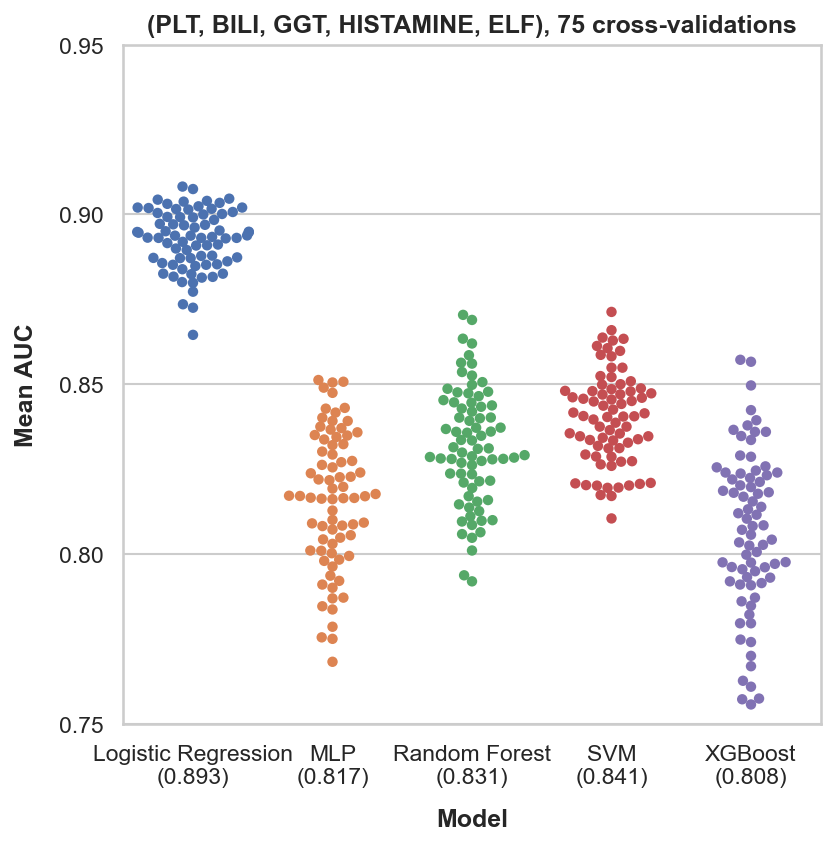

In [95]:
best = get_best_n_params_RFE(X_scaled, y, LogisticRegression(C = 0.6, max_iter=15000), 5)
print(best)

title =  "(" + ", ".join(best) + ")"
mean_AUCs = repeat_CV_get_AUC(models, names, 75, X_scaled[best], y, silent = False, analyze=True, title=title)

#### Standard workup, best 5

['PLT', 'BILI', 'CHE', 'GGT', 'aPTT']
Logistic Regression      ***************************************************************************
MLP                      ***************************************************************************
Random Forest            ***************************************************************************
SVM                      ***************************************************************************
XGBoost                  ***************************************************************************


,model,median of AUC means (75 cross-validations)
0,Logistic Regression,0.898
1,MLP,0.871
2,Random Forest,0.869
3,XGBoost,0.855
4,SVM,0.855


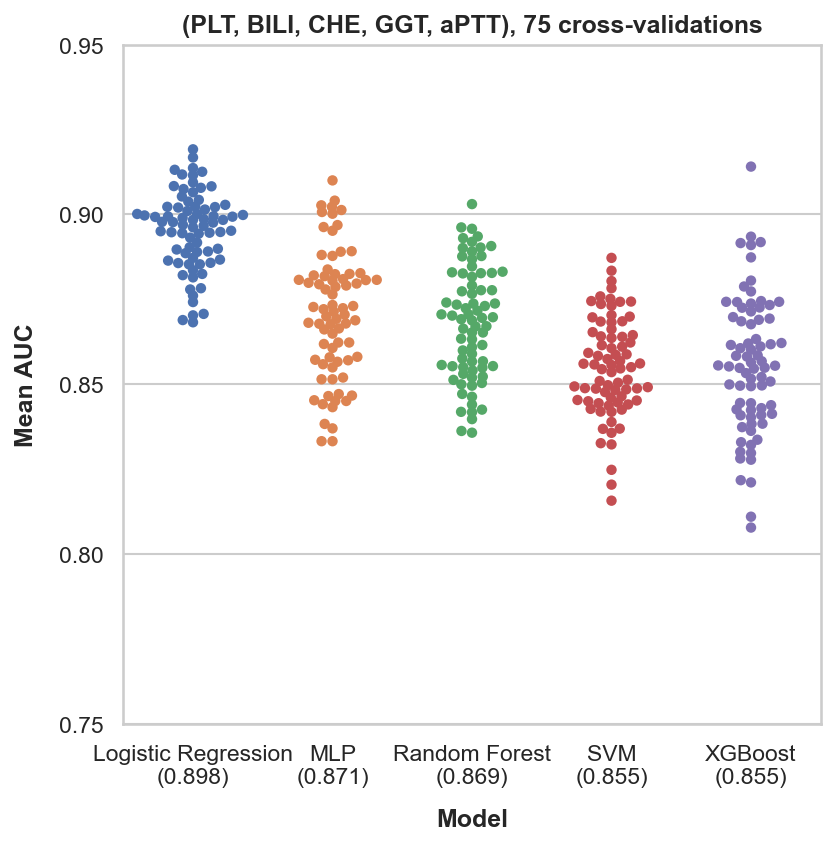

In [96]:
best = get_best_n_params_RFE(X_st, y, LogisticRegression(C = 0.6, max_iter=15000), 5)
print(best)

title =  "(" + ", ".join(best) + ")"
mean_AUCs = repeat_CV_get_AUC(models, names, 75, X_scaled[best], y, silent = False, analyze=True, title=title)

#### All variables, best 3

['PLT', 'BILI', 'ELF']
Logistic Regression      ***************************************************************************
MLP                      ***************************************************************************
Random Forest            ***************************************************************************
SVM                      ***************************************************************************
XGBoost                  ***************************************************************************


,model,median of AUC means (75 cross-validations)
0,Logistic Regression,0.882
1,MLP,0.870
2,SVM,0.835
3,Random Forest,0.830
4,XGBoost,0.817


/Users/jreinis/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


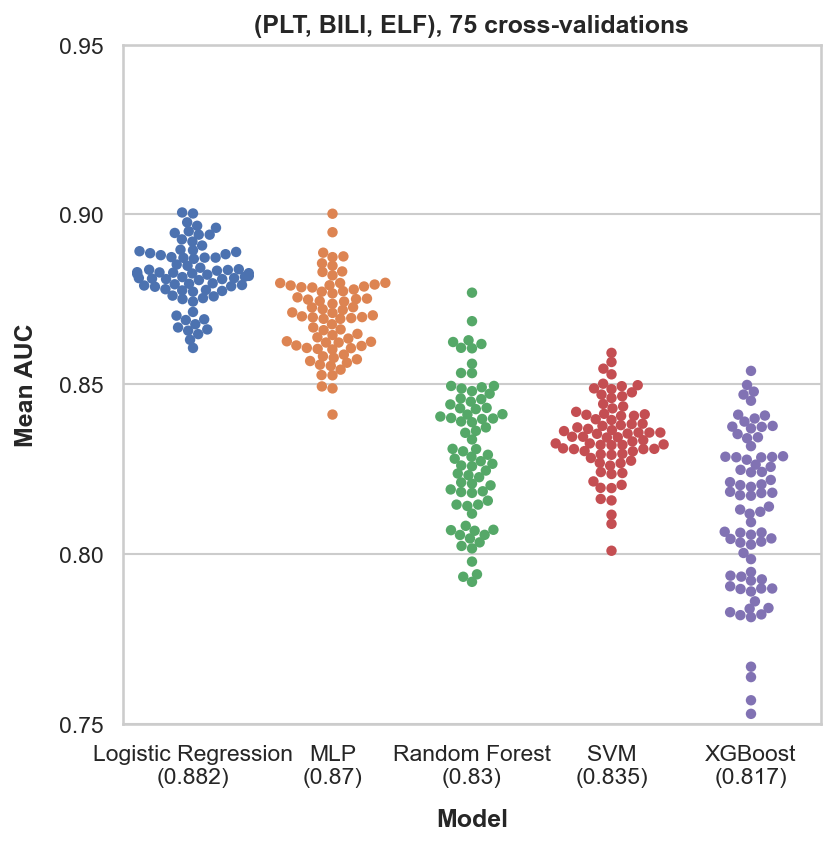

In [98]:
best = get_best_n_params_RFE(X_scaled, y, LogisticRegression(C = 0.6, max_iter=15000), 3)
print(best)

title =  "(" + ", ".join(best) + ")"
mean_AUCs = repeat_CV_get_AUC(models, names, 75, X_scaled[best], y, silent = False, analyze=True, title=title)

#### Standard workup, best 3

['PLT', 'BILI', 'aPTT']
Logistic Regression      ***************************************************************************
MLP                      ***************************************************************************
Random Forest            ***************************************************************************
SVM                      ***************************************************************************
XGBoost                  ***************************************************************************


,model,median of AUC means (75 cross-validations)
0,Random Forest,0.866
1,Logistic Regression,0.858
2,XGBoost,0.857
3,MLP,0.838
4,SVM,0.834


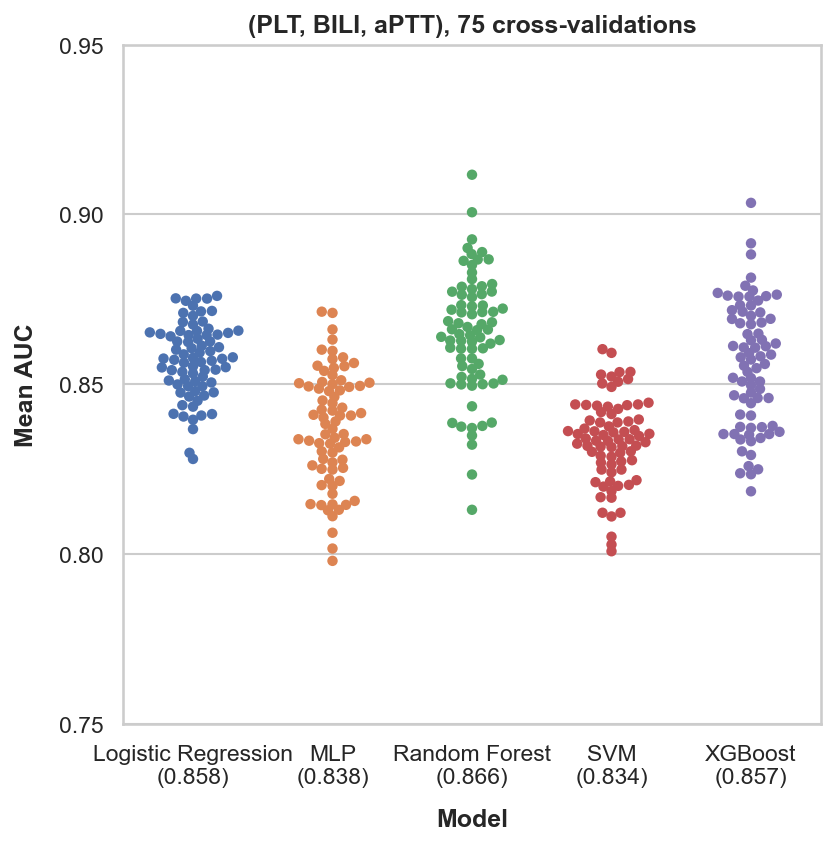

In [97]:
best = get_best_n_params_RFE(X_st, y, LogisticRegression(C = 0.6, max_iter=15000), 3)
print(best)

title =  "(" + ", ".join(best) + ")"
mean_AUCs = repeat_CV_get_AUC(models, names, 75, X_scaled[best], y, silent = False, analyze=True, title=title)